In [1]:
pip install -U scikit-learn scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
!export ARCHFLAGS="-arch arm64"

In [3]:
!python setup.py clean --all
!python 'setup.py' install
!python 'setup.py' build

running clean
removing 'build/temp.macosx-10.9-x86_64-3.9' (and everything under it)
removing 'build/lib.macosx-10.9-x86_64-3.9' (and everything under it)
removing 'build/bdist.macosx-10.9-x86_64' (and everything under it)
'build/scripts-3.9' does not exist -- can't clean it
removing 'build'
running install
running bdist_egg
running egg_info
writing data_depth.egg-info/PKG-INFO
writing dependency_links to data_depth.egg-info/dependency_links.txt
writing requirements to data_depth.egg-info/requires.txt
writing top-level names to data_depth.egg-info/top_level.txt
reading manifest file 'data_depth.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'data_depth.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.macosx-10.9-x86_64-3.9
creating build/lib.macosx-10.9-x86_64-3.9/depth
copying depth/conf.py -> build/lib.macosx-10.9-x86_64-3.9/depth
copying dept

11 warnings generated.
g++ -Wl, -shared -lstdc++ -arch x86_64 build/temp.macosx-10.9-x86_64-3.9/depth/src/depth_wrapper.o -lm -o build/lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so -rdynamic -std=c++14 -fPIC
ld: warning: ignoring duplicate libraries: '-lc++'
creating build/bdist.macosx-10.9-x86_64
creating build/bdist.macosx-10.9-x86_64/egg
copying build/lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so -> build/bdist.macosx-10.9-x86_64/egg
copying build/lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so -> build/bdist.macosx-10.9-x86_64/egg
creating build/bdist.macosx-10.9-x86_64/egg/depth
creating build/bdist.macosx-10.9-x86_64/egg/depth/multivariate
copying build/lib.macosx-10.9-x86_64-3.9/depth/multivariate/MCD.py -> build/bdist.macosx-10.9-x86_64/egg/depth/multivariate
copying build/lib.macosx-10.9-x86_64-3.9/depth/multivariate/L2.rst -> build/bdist.macosx-10.9-x86_64/egg/depth/multivariate
copying build/lib.macosx-10.9-x86_64-3.9/depth/multivariat

running build
running build_py
running egg_info
writing data_depth.egg-info/PKG-INFO
writing dependency_links to data_depth.egg-info/dependency_links.txt
writing requirements to data_depth.egg-info/requires.txt
writing top-level names to data_depth.egg-info/top_level.txt
reading manifest file 'data_depth.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'data_depth.egg-info/SOURCES.txt'
running build_ext


In [4]:
!find build/ -name "*.so"

build//bdist.macosx-10.9-x86_64/egg/ddalpha.cpython-39-darwin.so
build//bdist.macosx-10.9-x86_64/egg/depth_wrapper.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from depth.multivariate import *

Found ddalpha_exact: ['build/lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so']
Found ddalpha_approx: ['build/lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so']


## Create sample dataset
We use the multivariate_normal function in numpy, using the speficiations given in the Anomaly detection paper.

In [80]:
mean1 = (1, 1)
mean2 = (-3.181, -0.222)
cov1 = [[1, 1], [1, 2]]
cov2 = [[i / 36 for i in j] for j in cov1]

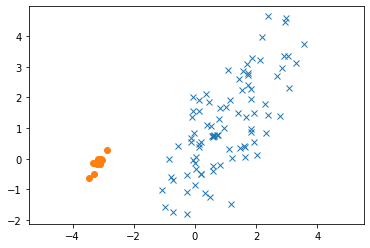

In [81]:
# use fixed random seed for reproducable results
rng = np.random.default_rng(322180440709489274700185804004290683059)
x, y = rng.multivariate_normal(mean1, cov1, 90).T
anom_x, anom_y = rng.multivariate_normal(mean2, cov2, 10).T

# Combine x and anom_x
combined_x = np.concatenate([x, anom_x])
combined_y = np.concatenate([y, anom_y])

# Plot the combined dataset
plt.plot(x, y, 'x')
plt.plot(anom_x, anom_y, 'o')
plt.axis('equal')
plt.show()

In [19]:
# compute combined dataset
combined_data = np.column_stack((combined_x, combined_y))
print(combined_x.shape, combined_data.shape)

(100,) (100, 2)


In [82]:
# compute projection depth for each point in the combined dataset
projection_depths = projection(combined_x, combined_data)
halfspace_depths = halfspace(combined_x, combined_data)
##TODO
projection_depths

array([0.37255472])

In [83]:
# compute Mahalanobis depth for each point in the combined dataset
mahalanobis_depths = mahalanobis(combined_x, combined_data)

array([0.25956178, 0.55487172, 0.70797631, 0.17837548, 0.13544755,
       0.64085091, 0.13561058, 0.26724042, 0.09699955, 0.15157437,
       0.30101819, 0.74736211, 0.2536117 , 0.33845775, 0.07574317,
       0.08181089, 0.39785784, 0.5155666 , 0.111964  , 0.1895685 ,
       0.46783102, 0.10751495, 0.34715342, 0.4774942 , 0.47374706,
       0.16445308, 0.20892556, 0.20719011, 0.51788056, 0.36332914,
       0.09605636, 0.71844961, 0.19579677, 0.39522341, 0.3452851 ,
       0.45887993, 0.1969201 , 0.7190814 , 0.10647352, 0.38284653,
       0.19803965, 0.60743624, 0.0906327 , 0.44980073, 0.22459434,
       0.05909762, 0.06166042, 0.05711824, 0.06099291, 0.05529962,
       0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 ,
       0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 ,
       0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 ,
       0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 ,
       0.4338208 , 0.4338208 , 0.4338208 , 0.4338208 , 0.43382

In [28]:
# compute simplicial depth for each point in the combined dataset
simplicial_depths = simplicial(combined_x, combined_data)

In [29]:
# compute convex hull peeling depth for each point in the combined dataset
convex_hull_depths = qhpeeling(combined_x, combined_data)

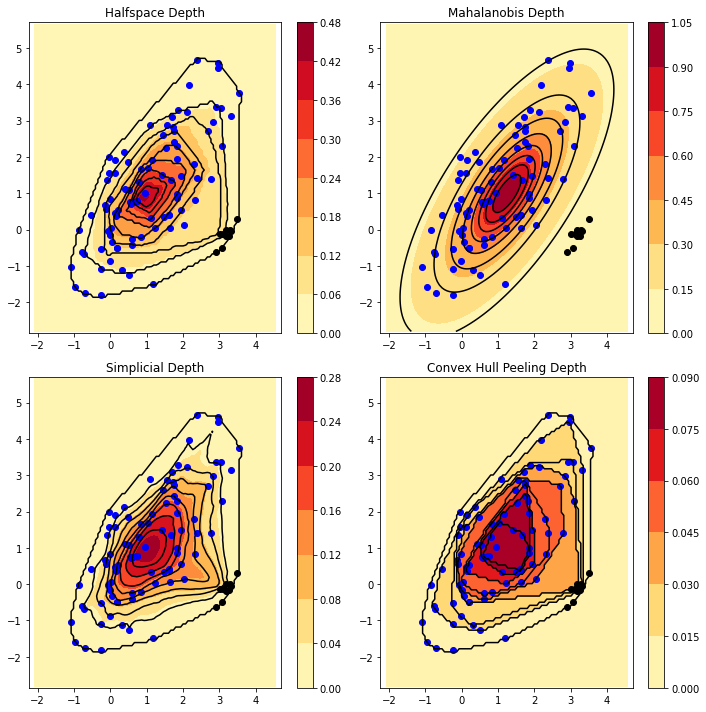

In [59]:
# Function to plot depth contours
def plot_depth_contours(ax, depth_function, title):
    # Create grid for plotting
    grid_x, grid_y = np.mgrid[combined_x.min()-1:combined_x.max()+1:100j, combined_y.min()-1:combined_y.max()+1:100j]
    grid = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    
    # Compute depth on the grid
    grid_depths = depth_function(grid, combined_data)
    grid_depths = grid_depths.reshape(grid_x.shape)
    
    # Plot depth contours
    contour = ax.contourf(grid_x, grid_y, grid_depths, cmap="YlOrRd")
    ax.contour(grid_x, grid_y, grid_depths, colors='k', levels=np.linspace(grid_depths.min(), grid_depths.max(), 10))
    ax.scatter(x, y, c='blue', label='Data points')
    ax.scatter(anom_x, anom_y, c='black', label='Data points')
    
    # Add a color bar
    fig.colorbar(contour, ax=ax, orientation='vertical')

    ax.set_title(title)
    ax.axis('equal')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_depth_contours(axs[0, 0], halfspace, "Halfspace Depth")
plot_depth_contours(axs[0, 1], mahalanobis, "Mahalanobis Depth")
plot_depth_contours(axs[1, 0], simplicial, "Simplicial Depth")
plot_depth_contours(axs[1, 1], qhpeeling, "Convex Hull Peeling Depth")

plt.tight_layout()
plt.show()

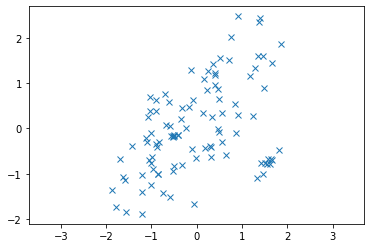

In [84]:
from scipy import stats
zscores = stats.zscore(combined_data, axis=0, ddof=1)

# separate zscores greater than 3
zx = zscores[:,0]
zy = zscores[:,1]

# Plot the combined dataset
plt.plot(zx, zy, 'x')
# plt.plot(x, y, 'x')
# plt.plot(anom_x, anom_y, 'o')
plt.axis('equal')
plt.show()